# *Training Model*

In [1]:
import os
import sys
import json
import numpy as np
import time
from PIL import Image, ImageDraw
import skimage.draw
import random


In [2]:
ROOT_DIR = 'C:\\Users\\L21003595\\Documents\MaskRCNN'
assert os.path.exists(ROOT_DIR), 'ROOT_DIR does not exist'

sys.path.append(ROOT_DIR) 

from mrcnn import visualize
from mrcnn.config import Config
from mrcnn import model as modellib, utils

In [3]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

In [4]:
class CustomConfig(Config):
    """Configuration for training on the helmet  dataset.
    """
    # Give the configuration a recognizable name
    NAME = "object"

    # Train on 1 GPU and 1 image per GPU. Batch size is 1 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 2  # background + objetos # FreeMonocytes and IngestedAdheredMonocytes

    # Relative path to .h5 weights file
   ## WEIGHTS_FILE = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
    
    # All of our training images are 512x512
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512

    # You can experiment with this number to see if it improves training
    STEPS_PER_EPOCH = 500

    # This is how often validation is run. If you are using too much hard drive space
    # on saved models (in the MODEL_DIR), try making this value larger.
    VALIDATION_STEPS = 5
    
    # Matterport originally used resnet101, but I downsized to fit it on my graphics card
    BACKBONE = 'resnet101'

    # To be honest, I haven't taken the time to figure out what these do
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 50 
    POST_NMS_ROIS_INFERENCE = 500 
    POST_NMS_ROIS_TRAINING = 1000 
    
config = CustomConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [5]:
class CustomDataset(utils.Dataset):
 
    def load_custom(self, dataset_dir, subset):
        """Load a subset of the bottle dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("object", 1, "FreeMonocytes")
        self.add_class("object", 2, "IngestedAdheredMonocytes")
 
        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)
 
        # Load annotations
        # VGG Image Annotator saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # We mostly care about the x and y coordinates of each region
        annotations1 = json.load(open(os.path.join(dataset_dir, "via_region_data.json")))
        # print(annotations1)
        annotations = list(annotations1.values())  # don't need the dict keys
 
        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]
 
        # Add images
        for a in annotations:
            # print(a)
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. There are stores in the
            # shape_attributes (see json format above)
          
            polygons = [r['shape_attributes'] for r in a['regions'].values()]
            objects = [s['region_attributes']['objetos'] for s in a['regions'].values()]

            name_dict = {"FreeMonocytes": 1,"IngestedAdheredMonocytes": 2}
            num_ids = [name_dict[a] for a in objects]
            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            #print("numids",num_ids)
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]
 
            self.add_image(
                "object",  ## for a single class just add the name here
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                num_ids=num_ids)
 
    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a bottle dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)
 
        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        if info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)
        num_ids = info['num_ids']
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1
 
        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        # Map class names to class IDs.
        num_ids = np.array(num_ids, dtype=np.int32)
        return mask, num_ids
 
    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "object":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)
 

# Loading Train and Validation Dataset

In [6]:
dataset_train = CustomDataset()
dataset_train.load_custom("C:\\Users\\L21003595\\Documents\\MaskRCNN\\images", "train")
dataset_train.prepare()
#dataset_train = r"C:\\Users\\L21003595\\Documents\\MaskRCNN\\images", "train"

# Validation dataset
dataset_val = CustomDataset()
dataset_val.load_custom("C:\\Users\\L21003595\\Documents\\MaskRCNN\\images", "val")
dataset_val.prepare()
#dataset_train = r("C:\\Users\\L21003595\\Documents\\MaskRCNN\\images", "val")
print('train: %d' % len(dataset_train.image_ids))
print('validation: %d' % len(dataset_val.image_ids))

train: 86
validation: 73


# Build MaskRCNN Model

In [7]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


# Transfer Learning

In [8]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

33
C:\Users\L21003595\Documents\MaskRCNN\images\train\Snap-1054.jpeg


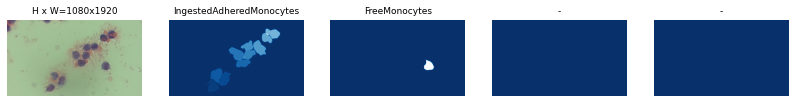

29
C:\Users\L21003595\Documents\MaskRCNN\images\train\Snap-1050.jpeg


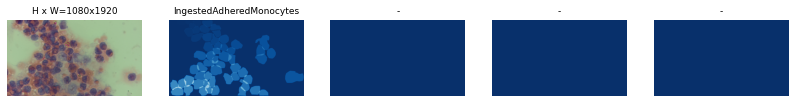

70
C:\Users\L21003595\Documents\MaskRCNN\images\train\Snap-1191.jpeg


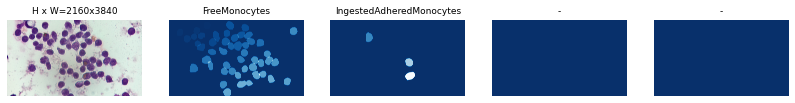

62
C:\Users\L21003595\Documents\MaskRCNN\images\train\Snap-1176.jpeg


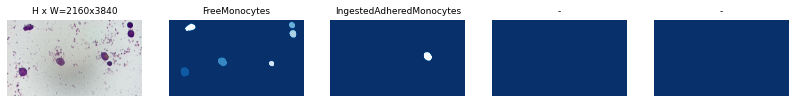

In [9]:
# Load and display random samples
dataset = dataset_train
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    print(image_id)
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    print(dataset.image_reference(image_id))
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

image_id  26 C:\Users\L21003595\Documents\MaskRCNN\images\train\Snap-995.jpeg
image                    shape: (1080, 1920, 3)       min:   24.00000  max:  246.00000  uint8
mask                     shape: (1080, 1920, 18)      min:    0.00000  max:    1.00000  uint8
class_ids                shape: (18,)                 min:    1.00000  max:    2.00000  int32
bbox                     shape: (18, 4)               min:    0.00000  max: 1916.00000  int32


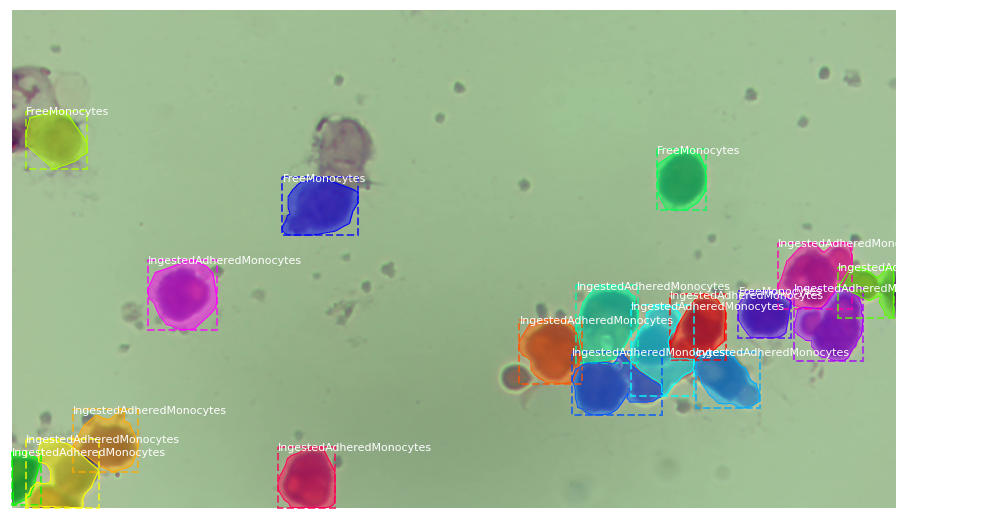

In [10]:
from mrcnn.model import log
# Load random image and mask.
image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

# *Training Weights*

In [11]:
model.train(dataset_train, dataset_val, 
            learning_rate=0.001, 
            epochs=20, 
            layers='heads')
            


Starting at epoch 0. LR=0.001

Checkpoint Path: C:\Users\L21003595\Documents\MaskRCNN\logs\object20221004T1535\mask_rcnn_object_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistrib

C:\Users\L21003595\Anaconda3\envs\MaskRCNN\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\L21003595\Anaconda3\envs\MaskRCNN\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\L21003595\Anaconda3\envs\MaskRCNN\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


500/500 [==============================] - 3006s 6s/step - loss: 1.2409 - rpn_class_loss: 0.0341 - rpn_bbox_loss: 0.4712 - mrcnn_class_loss: 0.3024 - mrcnn_bbox_loss: 0.2596 - mrcnn_mask_loss: 0.1736 - val_loss: 0.8700 - val_rpn_class_loss: 0.0138 - val_rpn_bbox_loss: 0.3334 - val_mrcnn_class_loss: 0.2947 - val_mrcnn_bbox_loss: 0.1051 - val_mrcnn_mask_loss: 0.1230
Epoch 2/20
500/500 [==============================] - 2400s 5s/step - loss: 0.7617 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.2214 - mrcnn_class_loss: 0.2188 - mrcnn_bbox_loss: 0.1532 - mrcnn_mask_loss: 0.1537 - val_loss: 0.9775 - val_rpn_class_loss: 0.0273 - val_rpn_bbox_loss: 0.3066 - val_mrcnn_class_loss: 0.2766 - val_mrcnn_bbox_loss: 0.1683 - val_mrcnn_mask_loss: 0.1986
Epoch 3/20
500/500 [==============================] - 2295s 5s/step - loss: 0.6225 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.1568 - mrcnn_class_loss: 0.1783 - mrcnn_bbox_loss: 0.1300 - mrcnn_mask_loss: 0.1457 - val_loss: 0.5766 - val_rpn_class_loss: 0.0

# *Testing the Model*

In [12]:
class InferenceConfig(CustomConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    #IMAGE_MIN_DIM = 512
    #IMAGE_MAX_DIM = 512
    DETECTION_MIN_CONFIDENCE = 0.6
    

inference_config = InferenceConfig()


In [13]:
class InferenceConfig(utils.Dataset):
 
    def load_custom(self, dataset_dir, subset):
        """Load a subset of the bottle dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("object", 1, "FreeMonocytes")
        self.add_class("object", 2, "IngestedAdheredMonocytes")
 
        # Train or validation dataset?
        assert subset in ["train", "val",'test']
        dataset_dir = os.path.join(dataset_dir, subset)
 
        # Load annotations
        # VGG Image Annotator saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # We mostly care about the x and y coordinates of each region
        annotations1 = json.load(open(os.path.join(dataset_dir, "via_region_data.json")))
        # print(annotations1)
        annotations = list(annotations1.values())  # don't need the dict keys
 
        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]
 
        # Add images
        for a in annotations:
            # print(a)
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. There are stores in the
            # shape_attributes (see json format above)
          
            polygons = [r['shape_attributes'] for r in a['regions'].values()]
            objects = [s['region_attributes']['objetos'] for s in a['regions'].values()]

            name_dict = {"FreeMonocytes": 1,"IngestedAdheredMonocytes": 2}
            num_ids = [name_dict[a] for a in objects]
            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            #print("numids",num_ids)
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]
 
            self.add_image(
                "object",  ## for a single class just add the name here
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                num_ids=num_ids)
 
    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a bottle dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)
 
        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        if info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)
        num_ids = info['num_ids']
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1
 
        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        # Map class names to class IDs.
        num_ids = np.array(num_ids, dtype=np.int32)
        return mask, num_ids
 
    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "object":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [14]:
# Testing dataset
dataset_test = InferenceConfig()
dataset_test.load_custom("C:\\Users\\L21003595\\Documents\\MaskRCNN\\images", "test")
dataset_test.prepare()

print('test: %d' % len(dataset_test.image_ids))

test: 10


In [15]:
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", config=inference_config,  model_dir=MODEL_DIR)

In [23]:
# Get path to saved weights
# Either set a specific path or find last trained weights
#model_path = os.path.join(ROOT_DIR, "C:\\Users\\L21003595\\Documents\\MaskRCNN\\logs\\mask_rcnn_object_0040.h5")
model_path = model.find_last()

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  C:\Users\L21003595\Documents\MaskRCNN\logs\object20221004T1535\mask_rcnn_object_0020.h5
Re-starting from epoch 20


C:\Users\L21003595\Documents\MaskRCNN\images\test\Snap-1193.jpeg
Processing 1 images
image                    shape: (2160, 3840, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  131.30000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 3840.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


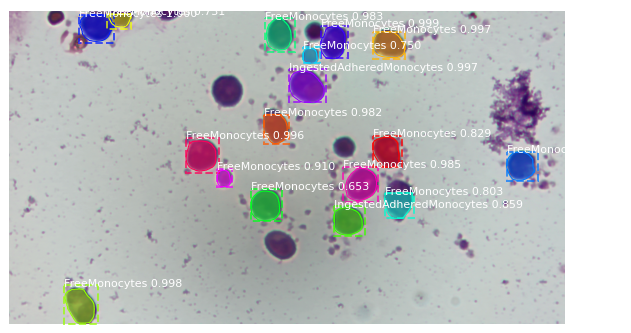

C:\Users\L21003595\Documents\MaskRCNN\images\test\Snap-1194.jpeg
Processing 1 images
image                    shape: (2160, 3840, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  130.30000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 3840.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


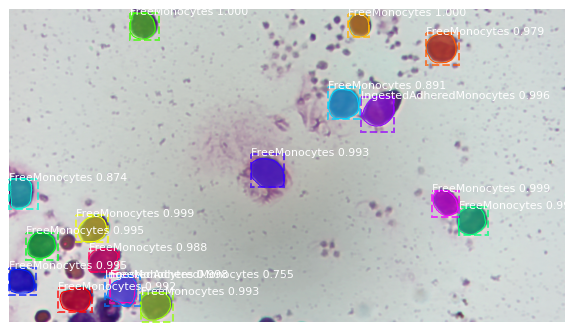

C:\Users\L21003595\Documents\MaskRCNN\images\test\Snap-1195.jpeg
Processing 1 images
image                    shape: (2160, 3840, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  138.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 3840.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


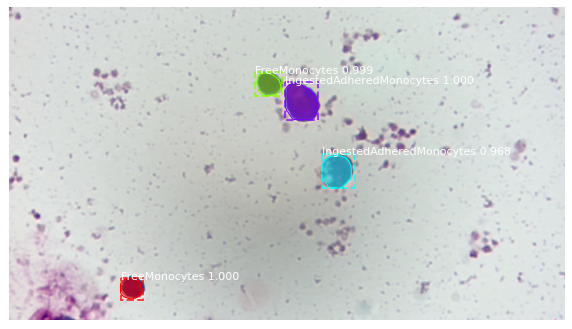

C:\Users\L21003595\Documents\MaskRCNN\images\test\Snap-1208.jpeg
Processing 1 images
image                    shape: (2160, 3840, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  129.30000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 3840.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


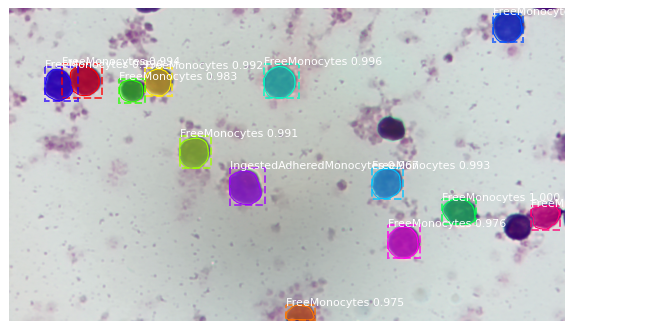

C:\Users\L21003595\Documents\MaskRCNN\images\test\Snap-1209.jpeg
Processing 1 images
image                    shape: (2160, 3840, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  136.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 3840.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


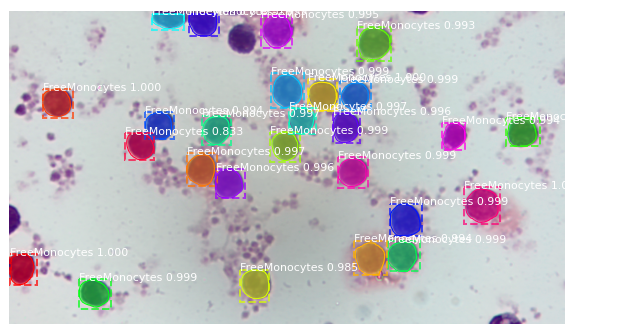

C:\Users\L21003595\Documents\MaskRCNN\images\test\Snap-1210.jpeg
Processing 1 images
image                    shape: (2160, 3840, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  136.20000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 3840.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


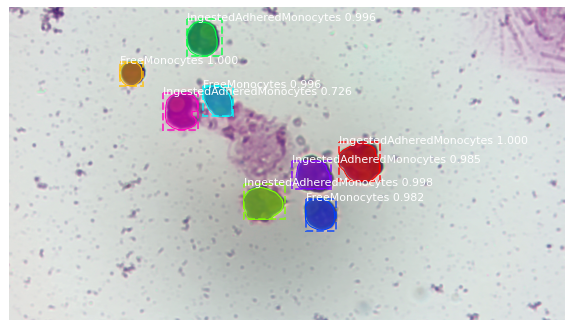

C:\Users\L21003595\Documents\MaskRCNN\images\test\Snap-1223.jpeg
Processing 1 images
image                    shape: (2160, 3840, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  133.20000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 3840.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


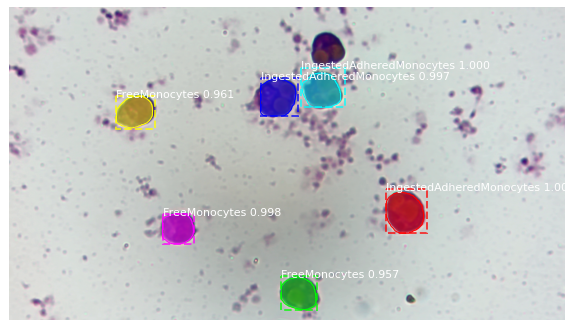

C:\Users\L21003595\Documents\MaskRCNN\images\test\Snap-1224.jpeg
Processing 1 images
image                    shape: (2160, 3840, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 3840.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


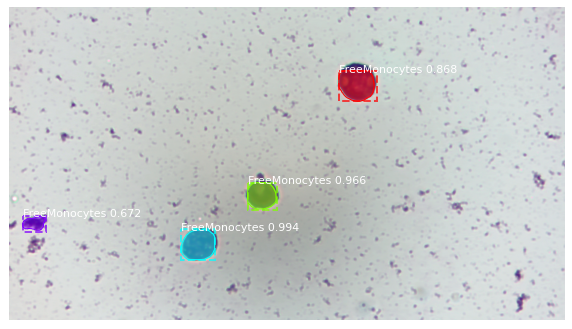

C:\Users\L21003595\Documents\MaskRCNN\images\test\Snap-1225.jpeg
Processing 1 images
image                    shape: (2160, 3840, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  134.20000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 3840.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


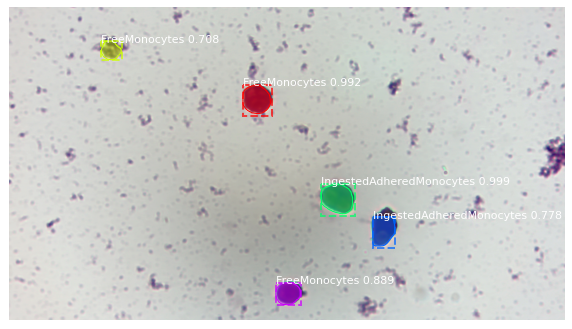

C:\Users\L21003595\Documents\MaskRCNN\images\test\Snap-1226.jpeg
Processing 1 images
image                    shape: (2160, 3840, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  147.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 3840.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


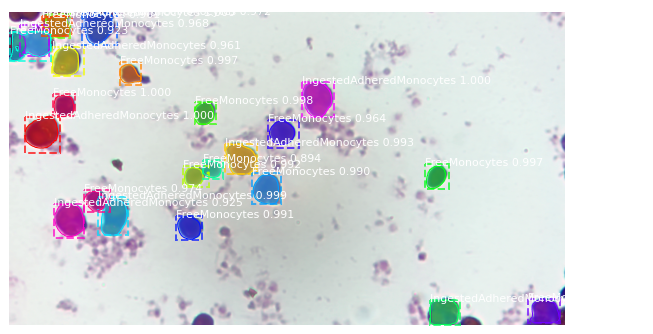

In [17]:
import skimage
import matplotlib.pyplot as plt

real_test_dir = 'C:\\Users\\L21003595\\Documents\\MaskRCNN\\images\\test'
image_paths = []
for filename in os.listdir(real_test_dir):
    if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg']:
        image_paths.append(os.path.join(real_test_dir, filename))

for image_path in image_paths:
    img = skimage.io.imread(image_path)
    
    if img.ndim != 3:
      image = skimage.color.gray2rgb(img)
    elif img.shape[-1] == 4:
      image = img[..., :3]
    else:
      image = img

    print(image_path)
    img_arr = np.array(image)
    results = model.detect([img_arr], verbose=1)
    r = results[0]
    visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                                dataset_val.class_names, r['scores'], figsize=(10,10))

# Confusion Matrix

In [18]:
# an example of plotting confusion matrix.
# the first step consists of computing ground-truth and prediction vectors for all images.
# using these vectors, the plot_confusion_matrix_from_data function plots the CM and computes tps fps and fns
import pandas as pd
import numpy as np
import os 

dataset = dataset_test
image_ids = np.random.choice(dataset.image_ids)

#ground-truth and predictions lists
gt_tot = np.array([])
pred_tot = np.array([])
#mAP list
mAP_ = []

image = np.array([])

#compute gt_tot, pred_tot for each image in the test dataset
for image_id in dataset.image_ids:                               # change this to test dataset
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset, config, image_id)
    info = dataset.image_info[image_id]

    # Run the model
    results = model.detect([image], verbose=1)
    r = results[0]
    
    #compute gt_tot and pred_tot
    gt, pred = utils.gt_pred_lists(gt_class_id, gt_bbox, r['class_ids'], r['rois'])
    gt_tot = np.append(gt_tot, gt)
    pred_tot = np.append(pred_tot, pred)

print(np.shape(image))
   
gt_tot=gt_tot.astype(int)
pred_tot=pred_tot.astype(int)
#save the vectors of gt and pred
save_dir = "output"
gt_pred_tot_json = {"gt_tot" : gt_tot, "pred_tot" : pred_tot}
df = pd.DataFrame(gt_pred_tot_json)
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
df.to_json(os.path.join(save_dir,"gt_pred_test.json"))


Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  131.30000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  int32
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  254.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  130.30000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  int32
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  138.10000

In [19]:
print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Image Count: 10
Class Count: 3
  0. BG                                                
  1. FreeMonocytes                                     
  2. IngestedAdheredMonocytes                          


C:\Users\L21003595\Documents\MaskRCNN\mrcnn\utils.py:1201: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
C:\Users\L21003595\Documents\MaskRCNN\mrcnn\utils.py:1202: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = False
C:\Users\L21003595\Documents\MaskRCNN\mrcnn\utils.py:1204: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
C:\Users\L21003595\Documents\MaskRCNN\mrcnn\utils.py:1205: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = False


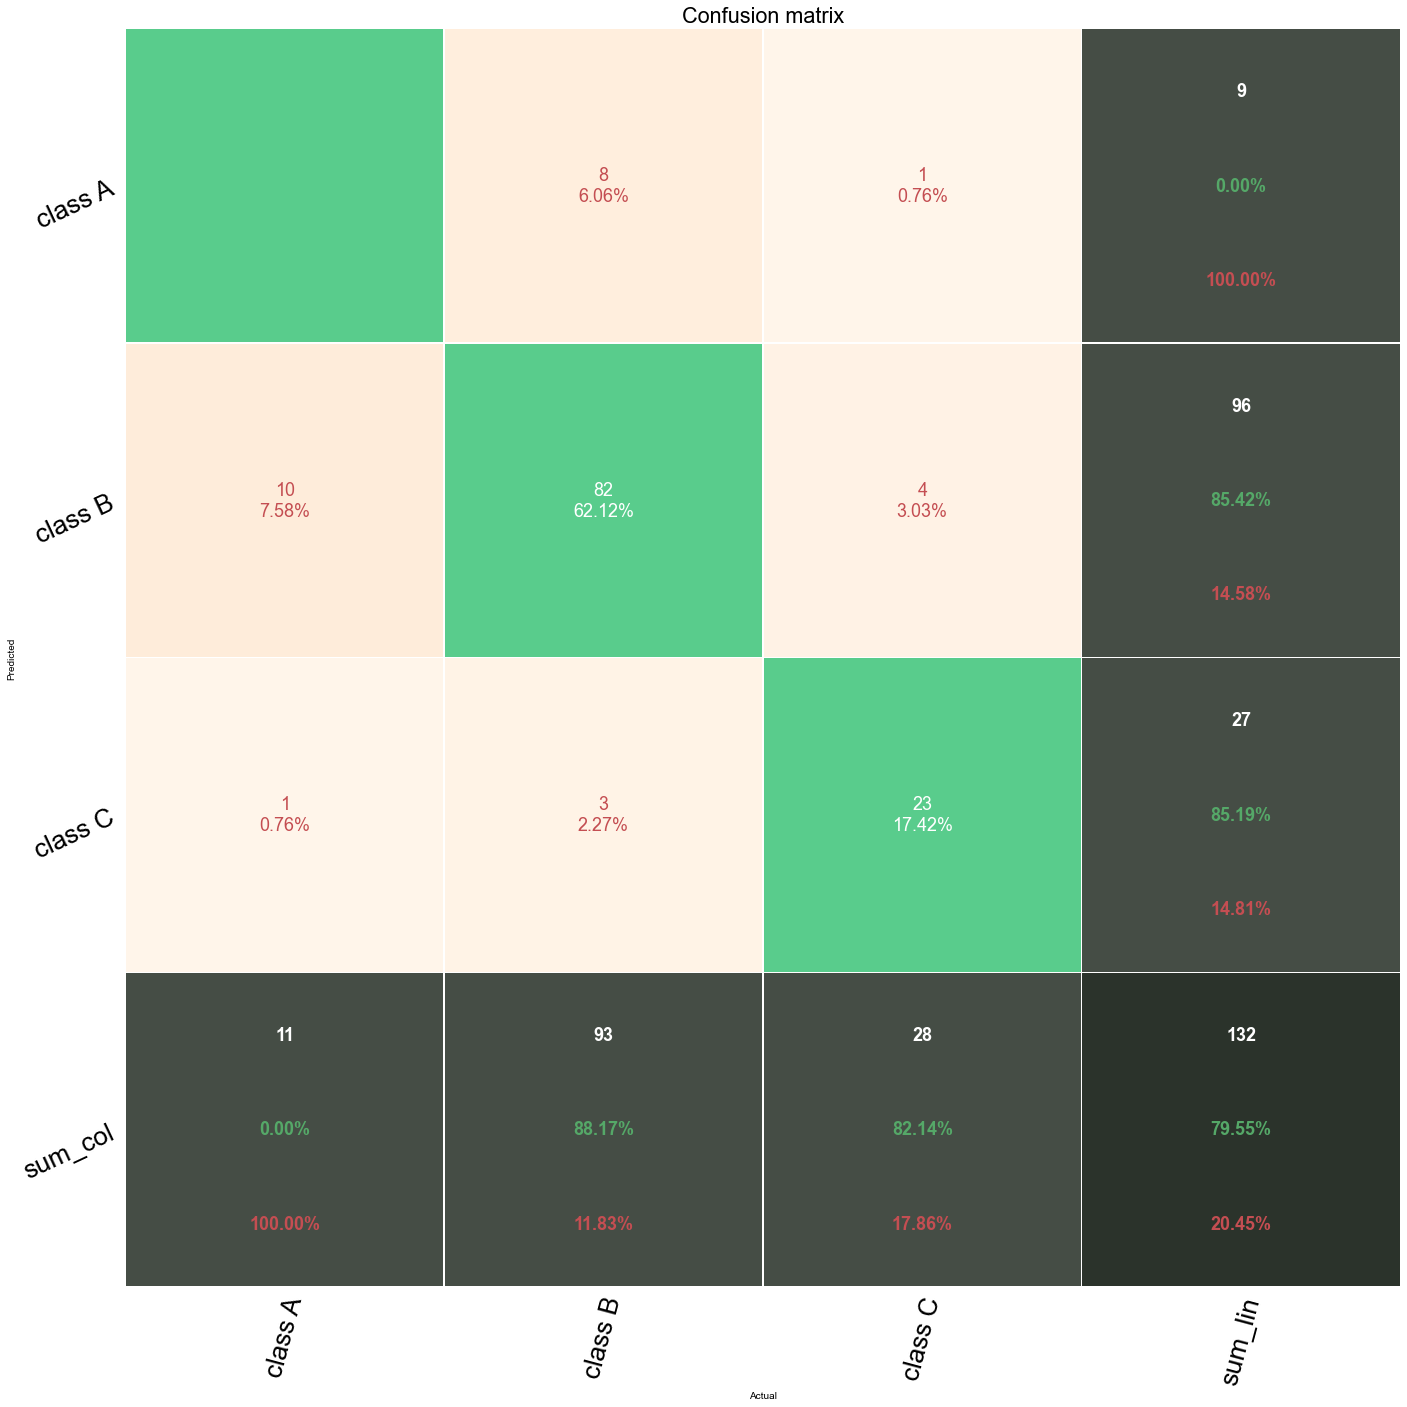

In [20]:
#it generates automatically a list from "class A" to "class ..". in this example, class A should be the background
#Note : class A is the backround in this example
tp,fp,fn=utils.plot_confusion_matrix_from_data(gt_tot,pred_tot,fz=18, figsize=(20,20), lw=0.5)

In [21]:
print("tp for each class :",tp)
print("fp for each class :",fp)
print("fn for each class :",fn)

#eliminate the background class (class A) from tps fns and fns lists since it doesn't concern us anymore : 
del tp[0]
del fp[0]
del fn[0]
print("\n########################\n")
print("tp for each class :",tp)
print("fp for each class :",fp)
print("fn for each class :",fn)

tp for each class : [0, 82, 23]
fp for each class : [11, 11, 5]
fn for each class : [9, 14, 4]

########################

tp for each class : [82, 23]
fp for each class : [11, 5]
fn for each class : [14, 4]


In [49]:
print('Accuracy =' ,((tp[0]+tp[1]+fn[0]+fn[1]) / (tp[0]+tp[1]+fn[0]+fn[1]+fp[0]+fn[1])) * 100)

Accuracy = 89.13043478260869


In [22]:
MMI = tp[1] / (tp[1]+tp[0])

print("FreeMonocytes = ", tp[0])
print("IngestedAdheredMonocytes = ", tp[1])
print("Total Number of Monocytes detected = ", tp[1]+tp[0])
print('Monocyte Monolayer Index % = ', MMI *100)

FreeMonocytes =  82
IngestedAdheredMonocytes =  23
Total Number of Monocytes detected =  105
Monocyte Monolayer Index % =  21.904761904761905


# Testing an Image out of Dataset

In [25]:
import warnings
warnings.filterwarnings('ignore')
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
import cv2
import random
import math
import re
import time
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg

from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
from mrcnn.visualize import display_instances
import mrcnn.model as modellib
from mrcnn.model import log
from mrcnn.config import Config
from mrcnn import model as modellib, utils

In [27]:
def get_ax(rows=1, cols=1, size=16):
  """Return a Matplotlib Axes array to be used in all visualizations in the notebook.  Provide a central point to control graph sizes. Adjust the size attribute to control how big to render images"""
  _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
  return ax

Images: 10
Classes: ['BG', 'FreeMonocytes', 'IngestedAdheredMonocytes']
Processing 1 images
image                    shape: (1080, 1920, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  138.20000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1920.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


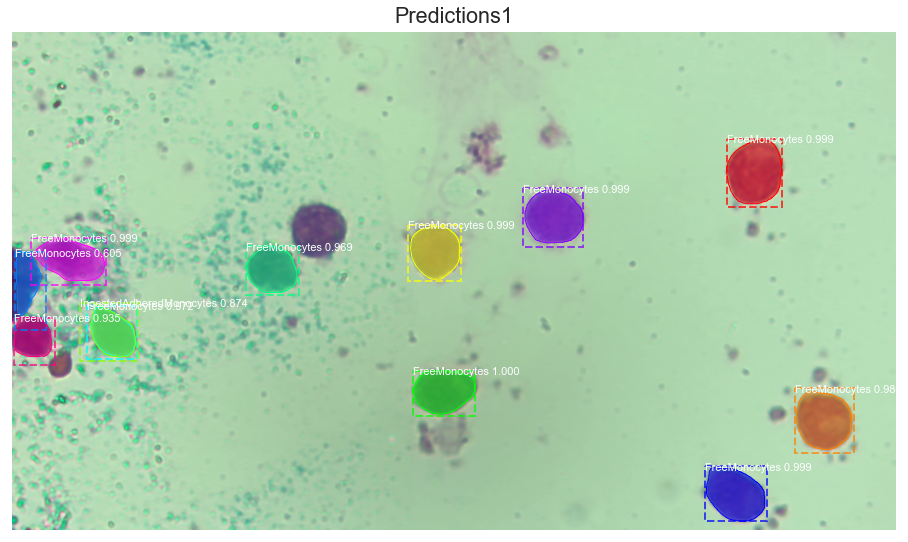

In [85]:
print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

# This is for predicting images which are not present in dataset
path_to_new_image = 'C:\\Users\\L21003595\\Documents\\MaskRCNN\\snap-51.jpg'
image1 = mpimg.imread(path_to_new_image)

# Run object detection
#print(len([image1]))
results1 = model.detect([image1], verbose=1)

# Display results
ax = get_ax(1)
r1 = results1[0]
visualize.display_instances(image1, r1['rois'], r1['masks'], r1['class_ids'],
dataset.class_names, r1['scores'], ax=ax, title="Predictions1")

In [86]:
value_to_count= np.array(r1['class_ids'])
unique, counts = np.unique(value_to_count, return_counts=True)
value_counted= np.asarray((unique, counts)).T

In [88]:
free = value_counted[0][1] 
ingested = value_counted[1][1]

print("Free Monocytes =" ,free)
print("Ingested/Adhered Monocytes =", ingested)
print("Total Monocytes Detected =", free + ingested)
print("Monocyte Monolayer Index % =", (ingested) / (free + ingested) * 100)

Free Monocytes = 11
Ingested/Adhered Monocytes = 1
Total Monocytes Detected = 12
Monocyte Monolayer Index % = 8.333333333333332


In [83]:
def calculate_MMI (result):
    value_to_count= np.array(r1['class_ids'])
    unique, counts = np.unique(value_to_count, return_counts=True)
    value_counted= np.asarray((unique, counts)).T
    
    print(r1['class_ids'])
    free = value_counted[0][1] 
    ingested = value_counted[1][1]

    print("Free Monocytes =" ,free)
    print("Ingested/Adhered Monocytes =", ingested)
    print("Total Monocytes Detected =", free + ingested)
    print("Monocyte Monolayer Index % =", (ingested) / (free + ingested) * 100)

In [84]:
calculate_MMI(r1)

[1 1 1 2 1 1 1 1 2 2 1 2 1 1 1 1 1 2 1 2 1 2 1 2]
Free Monocytes = 16
Ingested/Adhered Monocytes = 8
Total Monocytes Detected = 24
Monocyte Monolayer Index % = 33.33333333333333
